In [16]:
import geopandas as gpd
import numpy as np
import pandas as pd
from owslib.wms import WebMapService
import matplotlib.pyplot as plt
import shapely
from datetime import datetime
import datetime as dt
import os

In [87]:
#os.getcwd()

### Data Retrieval and Preprocessing: Web Scraping with BeautifulSoup

In [6]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup

In [17]:
def getStateUrls(url):
    """Returns list of state wildfire urls."""
    """Input: url - wildfire year url."""
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    state_urls = []
    for i,eachtag in enumerate(soup.findAll('a')):
        if i >0:
            statelink = eachtag['href']
            state_url = 'https://rmgsc.cr.usgs.gov' + statelink
            state_urls.append(state_url)
    return state_urls
        



In [ ]:
url_prefix = 'https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/201'
url_suffix = '_fire_data'
all_state_urls = []
for i in range(9,5,-1): 
    url = url_prefix + str(i) + url_suffix
    state_urls = getStateUrls(url)
    all_state_urls.extend(state_urls)    
    

    
#This assumes you create a 'GeomacData' folder in your current directory to store these files.
for eachstateurl in all_state_urls:
    urlnew = eachstateurl
    response = requests.get(urlnew)
    soup = BeautifulSoup(response.text, "html.parser")
    suburls_hrefs = soup.findAll('a')
    suburls_actual = [element['href'] for element in suburls_hrefs] 
    for i,suburl in enumerate(suburls_actual):    #for each fire url in state folder
        if i>0:
            #print(suburl)
            firelink = 'https://rmgsc.cr.usgs.gov' + suburl
            response = requests.get(firelink)
            soup = BeautifulSoup(response.text, "html.parser")  
            fire_evols = soup.findAll('a')   #list of shape files links in the fire's page.
            fire_shp_files = [element['href'] for element in fire_evols] 
            for j,fire_evol in enumerate(fire_shp_files):
                if j>0:
                    download_url = 'https://rmgsc.cr.usgs.gov' + fire_evol
                    storeurl = './GeomacData/'+ fire_evol.split("/")[-1]
                    urllib.request.urlretrieve(download_url,storeurl) 
                    time.sleep(1)




In [15]:
#all_state_urls

### Merging the scraped data

In [ ]:
files = os.listdir("./GeomacData")
path = [os.path.join("./GeomacData", i) for i in files if i.endswith('.shp')]

all_fires = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path], 
                        ignore_index=True), crs=gpd.read_file(path[0]).crs)


### CLEANING CERTAIN COLUMNS OF MERGED DATA.
all_fire_perims = all_fires.copy()

all_fire_perims['perDatTime'] = all_fire_perims['perDatTime'].combine_first(all_fires['PERDATTIME'])
all_fire_perims['fireName'] = all_fire_perims['perDatTime'].combine_first(all_fires['PERDATTIME'])
all_fire_perims['fireNum'] = all_fire_perims['perDatTime'].combine_first(all_fires['PERDATTIME'])
all_fire_perims['fireYear'] = all_fire_perims['perDatTime'].combine_first(all_fires['PERDATTIME'])
all_fire_perims['irwinid'] = all_fire_perims['irwinid'].combine_first(all_fires['IRWINID'])
all_fire_perims['state'] = all_fire_perims['state'].combine_first(all_fires['STATE'])
all_fire_perims['gisAcres'] = all_fire_perims['gisAcres'].combine_first(all_fires['GISACRES'])
all_fire_perims['incidentID'] = all_fire_perims['incidentID'].combine_first(all_fires['INCIDENTID'])

In [ ]:
#Saving data
all_fire_perims.to_file("all_fire_perimeters.shp")

## Get and Explore Saved Fire Perimeter Files

In [3]:
fire_perims = gpd.read_file("all_fire_perimeters.shp")

In [4]:
fire_perims.columns   #see column names, sometimes they change

Index(['ACTIVE', 'AGENCY', 'COMMENTS', 'COMPFIRECD', 'COMPLEXNM', 'COMPPARID',
       'ComplexN_1', 'DATECRNT', 'FIRECODE', 'FIRENAME', 'FIRENUM', 'FIREYEAR',
       'GISACRES', 'INCIDENTID', 'INCIWEBID', 'INCOMPLEX', 'IRWINID', 'LATEST',
       'MAPMETHOD', 'MERGEID', 'OBJECTID', 'PERDATTIME', 'SHAPE_AREA',
       'SHAPE_Ar_1', 'STATE', 'Shape_Ar_2', 'UNITIDOWN', 'UNITIDPROT',
       'active_1', 'agency_1', 'comments_1', 'compParI_1', 'compfire_1',
       'dateCrnt_1', 'fireName_1', 'fireNum_1', 'fireYear_1', 'firecode_1',
       'gisAcres_1', 'inComple_1', 'incident_1', 'inciwebI_1', 'irwinid_1',
       'latest_1', 'mapmetho_1', 'mergeid_1', 'objectid_1', 'perDatTi_1',
       'state_1', 'unitIDOw_1', 'unitIDPr_1', 'geometry'],
      dtype='object')

In [5]:
fire_perims.head()

,ACTIVE,AGENCY,COMMENTS,COMPFIRECD,COMPLEXNM,COMPPARID,ComplexN_1,DATECRNT,FIRECODE,FIRENAME,...,irwinid_1,latest_1,mapmetho_1,mergeid_1,objectid_1,perDatTi_1,state_1,unitIDOw_1,unitIDPr_1,geometry
0,N,BLM,Pulled from EGP REST Service,None,None,None,None,8/22/2019 5:05:50 AM,MNK0,Goshawk,...,{BFEB198B-0812-4365-9C6A-A0DBFFCFAC79},None,None,None,NaN,8/21/2019 4:29:27 PM,UT,None,None,"POLYGON ((-112.91023 40.81809, -112.91019 40.8..."
1,N,NPS,Pulled from EGP REST Service,None,None,None,None,6/30/2019 5:05:30 AM,L9EJ,6 MILE,...,{850dda2b-0d7d-4431-b2e2-32e045f5ecca},None,None,None,NaN,6/28/2019 11:43:31 AM,NV,None,None,"POLYGON ((-114.67735 35.45657, -114.67732 35.4..."
2,N,BLM,Pulled from EGP REST Service,None,None,None,None,8/13/2019 5:05:32 AM,MLY4,Flint Mesa,...,{D1DC65FB-1F52-4F22-8641-6AB763BE1A0F},None,None,None,NaN,8/12/2019 2:16:31 PM,ID,None,None,"POLYGON ((-115.18629 42.89051, -115.18617 42.8..."
3,N,BLM,Perimeter updated using Sentinel 2 image colle...,None,None,None,None,7/17/2019 8:39:52 AM,ME4Z,Tom Cook Slough 2,...,{5C63D91A-0865-4B63-8955-EBECD0C1DFAF},None,None,None,NaN,7/16/2019 3:46:33 PM,AK,None,None,"POLYGON ((-156.49420 65.92108, -156.49421 65.9..."
4,N,BLM,Pulled from EGP REST Service,None,None,None,None,7/11/2019 10:05:58 AM,MD8J,Devil Creek,...,{53e81281-a122-4c15-9395-ef1324528d63},None,None,None,NaN,7/11/2019 9:35:59 AM,ID,None,None,"POLYGON ((-114.93865 42.45531, -114.93869 42.4..."


## Downloading Sentinel Images to Match Perimeter Locations

Sentinel images are pictures of plots of land from the Sentinel Satelite with multiple types of features (vegetation, etc.). The images are taken every 5 days.

In [6]:
wms = WebMapService('http://services.sentinel-hub.com/ogc/wms/45271f49-0dcb-4329-8b35-8b6508fee50b')

### Preliminary exploration of WMS options/features

In [7]:
wms.identification.type
wms.identification.version
wms.identification.title
wms.identification.abstract

'The Copernicus project’s Sentinel satellites are revolutionizing earth observation (EO). Its free, full and open access to data with very short revisit times, high spatial resolution, and good spectral resolution are crucial for many applications. The portfolio of possible products is vast - use-cases of such a service range from plant health monitoring, land and water body change, flood monitoring, disaster mapping and more.However the current gap between Sentinel source data and its end-users is large:• \x90  ESA’s complex Scientific Data Hub• \x90  raster files are compressed with JPEG2000 (13 raster filesfor each product, one per spectral band)• \x90  terabytes of data per week• \x90  additional processing requirementsTackling the data in an old-fashioned way -  offering individual derivative products simply does not work anymore, the associated time and costs are large and defeat most of the major benefits of the Sentinel project.Our approach combines cloud-based GIS technologies

In [92]:
list(wms.contents)  #see list of options for types of features available from Sentinel Satelites

In [ ]:
wms['TRUE_COLOR'].styles 

In [ ]:
[op.name for op in wms.operations]

In [ ]:
wms.getOperationByName('GetMap').methods

In [ ]:
wms.getOperationByName('GetMap').formatOptions

### Image Retrieval

#### Explore getting a single image from wms

In [39]:
#Sample format
img = wms.getmap(    layers=['TRUE_COLOR'],
                     styles=['default'],
                     srs='EPSG:4326',
                     bbox=(-112.918670, 40.811920, -112.909857, 40.818094),
                     size=(256, 256),
                     format='image/png',
                     time ='2019-08-16/2019-08-21/P1D',                   
                     )

In [40]:
out = open('sentineltest.png', 'wb')  #
out.write(img.read())
out.close()

#### Explore getting a single image from wms using one of the perimeter images to find the correct location

In [41]:
#Sample with first element of polygon dataframe
test_polygon = fire_perims['geometry'][0]

ade = test_polygon.simplify(0.1, preserve_topology=True)  #simplify polygon to have fewer sides.
#print(ade)
print(ade.bounds)  #coordinates of bounding box of that polygon.

(-112.91863964999999, 40.812389912000064, -112.91022832499999, 40.81808935800009)


In [42]:
date = fire_perims['perDatTi_1'][0]
l = date.split('/')
date = l[0] + '/' + l[1] + '/' + l[2][:4]
print(date)

8/21/2019


In [43]:
fire_img = wms.getmap(  layers=['TRUE_COLOR'],
                     styles=['default'],
                     srs='EPSG:4326',
                     bbox=ade.bounds,
                     size=(256, 256),
                     #geometry = ade,
                     format='image/png',
                     #Transparent = False,
                     time ='2019-08-21/2019-08-30/P1D',                   
                     )

In [44]:
## Save downloaded image
out = open('sentinel_fire.png', 'wb')  #
out.write(fire_img.read())
out.close()

In [47]:
# get the same image from one month earlier
nofire_img = wms.getmap(  layers=['TRUE_COLOR'],
                     styles=['default'],
                     srs='EPSG:4326',
                     bbox=ade.bounds,
                     size=(256, 256),
                     #geometry = ade,
                     format='image/png',
                     #Transparent = False,
                     time ='2019-07-21/2019-07-30/P1D',                   
                     )

In [48]:
## Save downloaded image
out = open('sentinel_nofire.png', 'wb')  #
out.write(nofire_img.read())
out.close()

#### Loop through and download more images

In [89]:
fire_perims_small = fire_perims[0:15]

In [7]:
# get a single sentinel image for a given time
def getDownloadImage(polygonbounds, timeparams, fireBool, i, date):
    image = wms.getmap(layers=['TRUE_COLOR'],
                     styles=['default'],
                     srs='EPSG:4326',
                     bbox=polygonbounds,
                     size=(256, 256),  
                     format='image/png',
                     time = timeparams,                   
                     )
    ## Filename includes the date and whether or not there is supposed to be a fire
    filename = 'sentinel' + date + '_' + str(i) + str(fireBool) + '.png'
    d = Path().resolve().parent
    train_folder_path_fire = str(d) + '/Code/dataset/all_data/Fire2/'
    train_folder_path_no_fire = str(d) + '/Code/dataset/all_data/NoFire2/'
    
    if fireBool:
        fullfilename = train_folder_path_fire + filename
    else:
        fullfilename = train_folder_path_no_fire + filename
    #print(len(fullfilename))   
    if sys.getsizeof(image.read()) > 1000:
        out = open(fullfilename, 'wb')  #
        out.write(image.read())
        out.close()
    

In [91]:

def getSearchInterval(fire_perims, isFire):
    """Finds a 10 day time interval matching when fire happened for ith instance of a fire"""
    """For non-fire, check 5 months prior for same location where fire burned"""
    # pull date from fire_perims and reformat it
    date = fire_perims['perDatTi_1'][i]
    l = date.split('/')
    date = l[0] + '/' + l[1] + '/' + l[2][:4]
    
    # Reinterpret the date as a datetime and save as a string
    firedate = datetime.strptime(date, '%m/%d/%Y')
    firedate_str = firedate.strftime("%Y-%m-%d")
    
    if isFire:
        # Calculate the date that is 10 days in the future to be the end of the time interval we want an image
        interval_enddate = firedate + dt.timedelta(days = 5)  #can reduce if needed
        # interval_enddate = interval_enddate.now()
        interval_enddate_str = interval_enddate.strftime("%Y-%m-%d")
        # Construct date interval
        search_interval = firedate_str + '/' + interval_enddate_str + '/' + 'P1D'
    else:
        interval_startdate = firedate - dt.timedelta(days = 150)
        search_interval = interval_startdate + '/' + firedate_str  + '/' + 'P1D'
    
    return (search_interval, str(firedate.strftime("%Y")))


def downloadAllBurnImages(fire_perims, isFire):
    for i in range(len(fire_perims)):
        polygon = fire_perims['geometry'][i]
        polygon_simple = polygon.simplify(0.1, preserve_topology=True) 
        polygonbounds = polygon_simple.bounds
        (timeparams, fireDate) = getSearchInterval(fire_perims, i, isFire)
        getDownloadImage(polygonbounds, timeparams, isFire, i, fireDate) 
        
        



In [ ]:
isFire = True 
downloadAllBurnImages(fire_perims_small,isFire)  #Downloading True Labels with Fire
isFire = False
downloadAllBurnImages(fire_perims_small,isFire) #Downloading No Fire

# Deep Learning Modeling with Keras

###  Training_Validation_Test Data Split 

In [ ]:
#! pip install split-folders

In [ ]:
import split_folders
from pathlib import Path

d = Path().resolve().parent

input_folder = str(d) + '/dataset/all_data'
output_folder = str(d) + '/dataset/output'
split_folders.ratio(input_folder, output=output_folder, seed=1234, ratio=(.8, .1, .1))

### Defining the Model Architecture

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [ ]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Convolution2D(32, 3, 3, input_shape = (256, 256, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Convolution2D(32, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(output_dim = 128, activation = 'relu'))
classifier.add(Dense(output_dim = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Pointing Keras to Data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)



train_generator = train_datagen.flow_from_directory(r"./dataset/output/train/",
                                            target_size=(256, 256),
                                            color_mode="rgb",
                                            batch_size=32,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=42)

valid_generator = valid_datagen.flow_from_directory(directory=r"./dataset/output/val/",
                                            target_size=(256, 256),
                                            color_mode="rgb",
                                            batch_size=32,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=42)

test_generator = test_datagen.flow_from_directory(directory=r"./dataset/output/test/",
                                             target_size=(256, 256),
                                            color_mode="rgb",
                                            batch_size=32,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=42)


#https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

### Model Fitting

In [ ]:
classifier.fit_generator(training_set,
                         samples_per_epoch = 1000,  #8000,
                         nb_epoch = 10,
                         validation_data = valid_set,
                         nb_val_samples = 200 #2000
                        )

In [ ]:
classifier.evaluate_generator(generator=valid_set, steps=1)

### Prediction on Test set

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

In [ ]:
classifier.evaluate_generator(generator=test_set, steps=1)

### Saving Output on test set predictions to file

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

# Sentinelhub library approach to downloading sat images

In [70]:
from sentinelhub import SHConfig


INSTANCE_ID = '45271f49-0dcb-4329-8b35-8b6508fee50b'  # In case you put instance ID into configuration file you can leave this unchanged
CLIENT_ID = 'olamide'
CLIENT_SECRET = 'satellite'
if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
    #config.sh_client_id = CLIENT_ID
    #config.client_secret = CLIENT_SECRET
else:
    config = None

In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
import datetime
import numpy as np

import matplotlib.pyplot as plt

In [24]:
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox

## Exploration of how sentinelhub library works

In [2]:
# sentinelhub code
#credit: https://sentinelhub-py.readthedocs.io/en/latest/examples/ogc_request.html#Web-Map-Service-(WMS)-and-Web-Coverage-Service-(WCS)
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

### Explore one location

In [25]:
betsiboka_coords_wgs84 = [46.16, -16.15, 46.51, -15.58]
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)

In [31]:
wms_true_color_request = WmsRequest(
    layer='TRUE_COLOR',
    bbox=betsiboka_bbox,
    time='2017-12-15',
    width=512,
    height=856,
    config=config
)

In [32]:
wms_true_color_img = wms_true_color_request.get_data()

/anaconda3/lib/python3.7/site-packages/sentinelhub/download/sentinelhub_client.py:49: SHUserWarning: In order to achieve faster download performance please set configuration parameters 'sh_client_id' and 'sh_client_secret'
  warnings.warn(message, category=SHUserWarning)


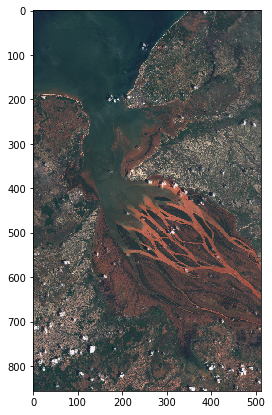

In [33]:
plot_image(wms_true_color_img[-1])

In [71]:
wcs_true_color_request = WcsRequest(
    layer='TRUE_COLOR',
    bbox=betsiboka_bbox,
    time='2017-12-15',
    resx='20m',
    resy='20m',
    config=config
)



In [72]:
wcs_true_color_img = wcs_true_color_request.get_data()

/anaconda3/lib/python3.7/site-packages/sentinelhub/download/sentinelhub_client.py:49: SHUserWarning: In order to achieve faster download performance please set configuration parameters 'sh_client_id' and 'sh_client_secret'
  warnings.warn(message, category=SHUserWarning)


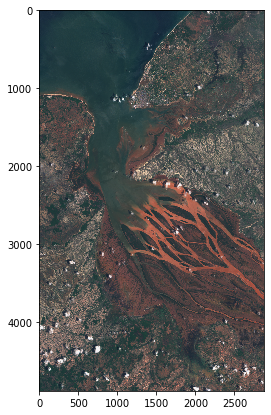

In [68]:
plot_image(wcs_true_color_img[0])

## Downloading Fire Location Training Data with Sentinelhub Library

In [6]:
def getSearchIntervalSH(fire_perims, isFire):
    """Finds a 10 day time interval matching when fire happened for ith instance of a fire"""
    """For non-fire, check 5 months prior for same location where fire burned"""
    # pull date from fire_perims and reformat it
    date = fire_perims['perDatTi_1'][i]
    l = date.split('/')
    date = l[0] + '/' + l[1] + '/' + l[2][:4]
    
    # Reinterpret the date as a datetime and save as a string
    firedate = datetime.strptime(date, '%m/%d/%Y')
    firedate_str = firedate.strftime("%Y-%m-%d")
    
    if isFire:
        # Calculate the date that is 10 days in the future to be the end of the time interval we want an image
        interval_enddate = firedate + dt.timedelta(days = 5)  #can reduce if needed
        # interval_enddate = interval_enddate.now()
        interval_enddate_str = interval_enddate.strftime("%Y-%m-%d")
        # Construct date interval
        return (firedate_str, interval_enddate_str)
    else:
        interval_startdate = firedate - dt.timedelta(days = 150)
        return (interval_startdate, firedate_str)



# get a single sentinel image for a given time
def getDownloadImageSentinelHub(polygonbounds, timeparams, fireBool, i, date):
    image = WcsRequest(layers='TRUE_COLOR',
                     bbox= list(polygonbounds),
                     resx='20m',
                     resy='20m', 
                     time=timeparams, 
                     image_format=MimeType.PNG,
                     time_difference=datetime.timedelta(hours=2),
                     maxcc=0.3,  #can delete
                     config = config
                     )
    ## Filename includes the date and whether or not there is supposed to be a fire
    filename = 'sentinel' + date + '_' + str(i) + str(fireBool) + '.png'
   
    train_folder_path_fire = str(d) + '/dataset/all_data/Fire2'
    train_folder_path_no_fire = str(d) + '/dataset/all_data/NoFire2'
    
    if fireBool:
        fullfilename = train_folder_path_fire + filename
    else:
        fullfilename = train_folder_path_no_fire + filename
        
    out = open(fullfilename, 'wb')  #
    out.write(image.read())
    out.close()


def downloadAllBurnImagesSH(fire_perims, isFire):
    for i in range(len(fire_perims)):
        polygon = fire_perims['geometry'][i]
        polygon_simple = polygon.simplify(0.1, preserve_topology=True) 
        polygonbounds = polygon_simple.bounds
        (timeparams, fireDate) = getSearchInterval(fire_perims, i, isFire)
        getDownloadImageSentinelHub(polygonbounds, timeparams, isFire, i, fireDate)


In [ ]:
isFire = True 
downloadAllBurnImagesSH(fire_perims_small,isFire)  #Downloading True Labels with Fire
isFire = False
downloadAllBurnImagesSH(fire_perims_small,isFire) #Downloading No Fire